In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from ast import increment_lineno
import tensorflow as tf
import tensorflow.keras as ks
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import Input, Model
import pandas as pd
import re
import random
import matplotlib.pyplot as plt
# %matplotlib inline 
%pip install segmentation_models
from segmentation_models import Unet, losses, metrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.6 MB/s 
Segmentation Models: using `keras` framework.


In [ ]:
dataset_img = []
dataset_mask = []
train_path = []
train_ID_path = []
val_path = []
val_ID_path = []

NUM_CLASSES = 4
IMAGE_WIDTH = 512 
BATCH_SIZE = 4
BUFFER_SIZE = 50
RESNET_BACKBONE = 'resnet50'
INCEPTION_BACKBONE = 'inceptionv3'
ENET_BACKBONE = 'efficientnetb4'

## Load dataset

In [ ]:
PATH = r'/content/drive/MyDrive/dataset/dataset_upload/'
IMAGE_FOLDER = 'imgFine'
LABEL_FOLDER = 'label'

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)


for folder in (os.listdir(PATH)):
  image_dir = PATH + folder + '/' + IMAGE_FOLDER 
  mask_dir = PATH + folder + '/' + LABEL_FOLDER
  for image_name in (sorted_alphanumeric(os.listdir(image_dir))):
    dataset_img.append(image_dir + '/' + image_name)
  for mask_name in (sorted_alphanumeric(os.listdir(mask_dir))):
    dataset_mask.append(mask_dir + '/' + mask_name)


print(len(dataset_img))
print(len(dataset_mask))

print(dataset_img[1])
print(dataset_mask[1])

114
114
/content/drive/MyDrive/dataset/dataset_upload/18/imgFine/18_pic2.png
/content/drive/MyDrive/dataset/dataset_upload/18/label/18_pic2_mask.png


## Shuffle the data

In [ ]:
random.Random(1337).shuffle(dataset_img)
random.Random(1337).shuffle(dataset_mask)
train_path = dataset_img[23:]
train_ID_path = dataset_mask[23:]
val_path = train_path[:23]
val_ID_path = train_ID_path[:23]

## Read image into dataset

In [ ]:
def read_image(image_path,mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1) # change PNG encoded image to uint8 tensor
        image.set_shape([None, None, 1]) #update the shape of tensor 
        image = tf.image.resize(images=image, size=[IMAGE_WIDTH, IMAGE_WIDTH])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_WIDTH, IMAGE_WIDTH])
        image = image / 255.0    #normalize image
    
    return image

def load_data(image_list,mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list,mask=True)

    return image,mask

def Augment(image, label):
  # image = tf.image.central_crop(image,central_fraction=0.5)
  image = tf.image.random_brightness(image, max_delta=0.5,seed = 1337)
  image = tf.image.random_flip_up_down(image,seed = 50)

  # label = tf.image.central_crop(label,central_fraction=0.5)
  label = tf.image.random_flip_up_down(label,seed = 50)

  return image, label

def data_generator_train(image_list,mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list,mask_list)) #create a dataset whose element is a slice of tensor
    dataset = dataset.map(load_data,num_parallel_calls=tf.data.AUTOTUNE,) # map the image and mask through map function load_data
    dataset = dataset.map(Augment)
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True) # combine consecutive image into small batch, drop_remainder helps to prevent smaller dimenstion be created
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def data_generator_val(image_list,mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list,mask_list)) #create a dataset whose element is a slice of tensor
    dataset = dataset.map(load_data,num_parallel_calls=tf.data.AUTOTUNE,) # map the image and mask through map function load_data
    dataset = dataset.map(Augment)
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True) # combine consecutive image into small batch, drop_remainder helps to prevent smaller dimenstion be created       drop_remainder=True
    return dataset

## Generate dataset

In [ ]:
train_dataset = data_generator_train(train_path,train_ID_path)
val_dataset = data_generator_val(val_path,val_ID_path)

## Define U-net model with backbone

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
def U_net_option(image_width, image_height, class_num,backbone):
    model = Unet(backbone, encoder_weights='imagenet', classes=class_num, input_shape=(image_width,image_height,3))
    return model

#model_resnet = U_net_option(IMAGE_WIDTH,IMAGE_WIDTH,NUM_CLASSES,RESNET_BACKBONE)
model_inception = U_net_option(IMAGE_WIDTH,IMAGE_WIDTH,NUM_CLASSES,INCEPTION_BACKBONE)
#model_resnet = U_net_option(IMAGE_WIDTH,IMAGE_WIDTH,NUM_CLASSES,ENET_BACKBONE)
#model_e_net.summary()

87924736/87910968 [==============================] - 3s 0us/step


## Define loss function

In [ ]:
weights = np.array([1.0, 2.0, 8.0, 8.0])
weights_fraction = weights / np.sum(weights)
dice_loss = losses.DiceLoss(class_weights=weights_fraction)
focal_loss = losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss

## Define metrics

In [ ]:
metrics = [metrics.IOUScore(threshold = 0.5),metrics.FScore(threshold=0.5)]

## Compile and fit model with backprop

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/dataset/SGScape_Unet_resnetv2.h5',save_best_only=True)]
model_resnet.compile(optimizer = 'Adam',loss = total_loss,metrics = metrics)
history = model_resnet.fit(train_dataset, validation_data = val_dataset, epochs = 32, callbacks = callbacks)

Epoch 1/32
22/22 [==============================] - 749s 30s/step - loss: 0.8390 - iou_score: 0.5608 - f1-score: 0.6913 - val_loss: 0.7995 - val_iou_score: 0.5690 - val_f1-score: 0.7024
Epoch 2/32
22/22 [==============================] - 705s 31s/step - loss: 0.7903 - iou_score: 0.7846 - f1-score: 0.8505 - val_loss: 0.7884 - val_iou_score: 0.7851 - val_f1-score: 0.8772
Epoch 3/32
22/22 [==============================] - 719s 32s/step - loss: 0.7734 - iou_score: 0.9596 - f1-score: 0.9762 - val_loss: 0.7828 - val_iou_score: 0.8070 - val_f1-score: 0.8903
Epoch 4/32
22/22 [==============================] - 713s 32s/step - loss: 0.7615 - iou_score: 1.0101 - f1-score: 1.0037 - val_loss: 0.7762 - val_iou_score: 0.8498 - val_f1-score: 0.9170
Epoch 5/32
22/22 [==============================] - 716s 32s/step - loss: 0.7572 - iou_score: 1.0197 - f1-score: 1.0079 - val_loss: 0.7638 - val_iou_score: 0.9330 - val_f1-score: 0.9634
Epoch 6/32
22/22 [==============================] - 728s 32s/step - lo

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/dataset/SGScape_Unet_inceptionv2.h5',save_best_only=True)]
model_inception.compile(optimizer = 'Adam',loss = total_loss,metrics = metrics)
history_inception = model_inception.fit(train_dataset, validation_data = val_dataset, epochs = 32, callbacks = callbacks)

Epoch 1/32
22/22 [==============================] - 39s 626ms/step - loss: 0.8460 - iou_score: 0.5480 - f1-score: 0.6793 - val_loss: 2.1364 - val_iou_score: 0.0952 - val_f1-score: 0.1368
Epoch 2/32
22/22 [==============================] - 32s 657ms/step - loss: 0.7925 - iou_score: 0.7827 - f1-score: 0.8535 - val_loss: 0.8643 - val_iou_score: 0.3787 - val_f1-score: 0.5429
Epoch 3/32
22/22 [==============================] - 29s 465ms/step - loss: 0.7773 - iou_score: 0.8457 - f1-score: 0.9005 - val_loss: 0.8643 - val_iou_score: 0.3788 - val_f1-score: 0.5430
Epoch 4/32
22/22 [==============================] - 27s 446ms/step - loss: 0.7664 - iou_score: 0.9720 - f1-score: 0.9839 - val_loss: 0.8648 - val_iou_score: 0.3849 - val_f1-score: 0.5500
Epoch 5/32
22/22 [==============================] - 31s 643ms/step - loss: 0.7599 - iou_score: 1.0011 - f1-score: 0.9992 - val_loss: 0.8359 - val_iou_score: 0.5364 - val_f1-score: 0.6947
Epoch 6/32
22/22 [==============================] - 27s 434ms/ste

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/dataset/SGScape_Unet_enet.h5',save_best_only=True)]
model_e_net.compile(optimizer = 'Adam',loss = total_loss,metrics = metrics)
history_enet = model_e_net.fit(train_dataset, validation_data = val_dataset, epochs = 32, callbacks = callbacks)

Epoch 1/32


## Plot the loss and metrics graphs for Res Net setting



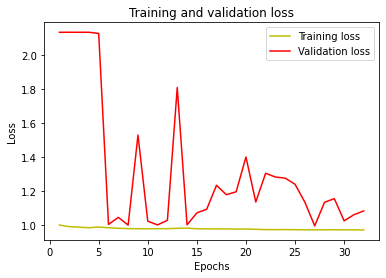

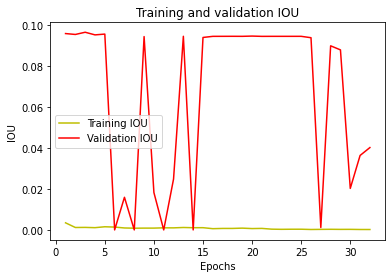

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()


## Plot the loss and metrics graphs for Inception setting

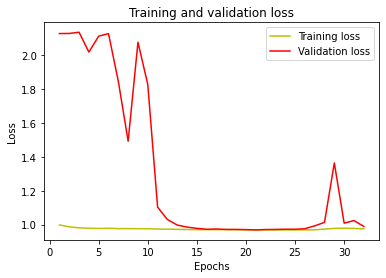

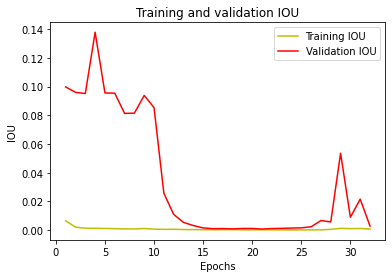

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_inception.history['iou_score']
val_acc = history_inception.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()


## Plot the loss and metrics graphs for Enet setting

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_enet.history['loss']
val_loss = history_enet.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_enet.history['iou_score']
val_acc = history_enet.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()
